In [1]:
# Import packages
import sys
import pandas as pd
import seaborn as sn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set preferences
tf.random.set_seed(42)
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# import local modules
sys.path.append('../src')
from Fishnet import Fishnet

# update local libraries automatically
%load_ext autoreload
%autoreload 2

# Predicting Urbanization *Rate* Using Convolutional LSTMs

`Author:` Andrea Zanon, Victor Radermecker

`Date:` Tuesday, July 18th

In this Jupyter Notebook, we predict urbanization rate using a Convolution Long Short Term Memory model. The training data consists of Dynamic World labels, extracted using the Fishnet Class. 

_Data Loading_:

A CSV of the following structure should be loaded to run the following model. This dataframe can be obtained using the `DataPreprocessing.ipynb` file from the package. This Notebook requires having a `Fishnet` object that be generated using the `DataExporter.py` and `DataPreprocessing.py`. Each .CSV dataset comes with a metadata .txt file, that contains useful information such as the number of rows and columns in the fishnet. These values are necessary to run this Notebook. The second cell below prints the information contains in the metadata file.

<table>
  <thead>
    <tr>
      <th>idx</th>
      <th>tile_id</th>
      <th>batch_id</th>
      <th>year</th>
      <th>urbanization_rate</th>
      <th>urbanization</th>
      <th>Lat</th>
      <th>Lon</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2017</td>
      <td>0.063333</td>
      <td>0.710556</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>1</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2018</td>
      <td>0.097778</td>
      <td>0.773889</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>2</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2019</td>
      <td>-0.010556</td>
      <td>0.871667</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>3</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2020</td>
      <td>0.025000</td>
      <td>0.861111</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
    <tr>
      <td>4</td>
      <td>6060154</td>
      <td>23743</td>
      <td>2021</td>
      <td>0.027778</td>
      <td>0.886111</td>
      <td>29.793894</td>
      <td>-95.801855</td>
    </tr>
  </tbody>
</table>


In [2]:
data = pd.read_csv('../Results/urbanization_data_large_texas.csv')
data.head()

,tile_id,batch_id,year,urbanization_rate,urbanization,Lat,Lon
0,4879217,1225,2017,0.0,0.0,31.100095,-99.130546
1,4879217,1225,2018,0.0,0.0,31.100095,-99.130546
2,4879217,1225,2019,0.0,0.0,31.100095,-99.130546
3,4879217,1225,2020,0.0,0.0,31.100095,-99.130546
4,4879217,1225,2021,0.0,0.0,31.100095,-99.130546


In [3]:
# read and print a text file
with open('../Results/urbanization_data_large_texas.txt', 'r') as f:
    print(f.read())



General Fishnet Information:
+----------------+-----------------------+-------------------+
|     Metric     |        Degrees        |       Miles       |
+----------------+-----------------------+-------------------+
| Fishnet Width  |   13.138423211000031  | 817.0318617424371 |
| Fishnet Height |   10.663161770999977  |  736.75306466581  |
|  Tiles Width   |  0.004020157322514706 |        0.25       |
|  Tiles Height  | 0.0036182855831725647 |        0.25       |
+----------------+-----------------------+-------------------+



General Batch Information:
+---------+---------+---------+
|  Metric |  Tiles  | Batches |
+---------+---------+---------+
|   Rows  |   2948  |    47   |
| Columns |   3269  |    52   |
|  Cells  | 9637012 |   2444  |
+---------+---------+---------+


General Filter Information:
Filtered region: [-99.13,28.91,-94.29,31.1,]
Number of rows: 606
Number of cols: 1205


# Tensor Generation

In [4]:
# Generate tensor
rows = 606
cols = 1205
years = [2017, 2018, 2019, 2020, 2021, 2022]
tensor = np.zeros((len(years), rows, cols, 1))

for yr in tqdm(years):
    tensor[years.index(yr), :, :, 0] = data[data["year"]== yr]["urbanization_rate"].to_numpy().reshape(rows, cols)

100%|██████████| 6/6 [00:00<00:00, 43.14it/s]


In [5]:
tensor.shape

(6, 606, 1205, 1)

# Data Visualization

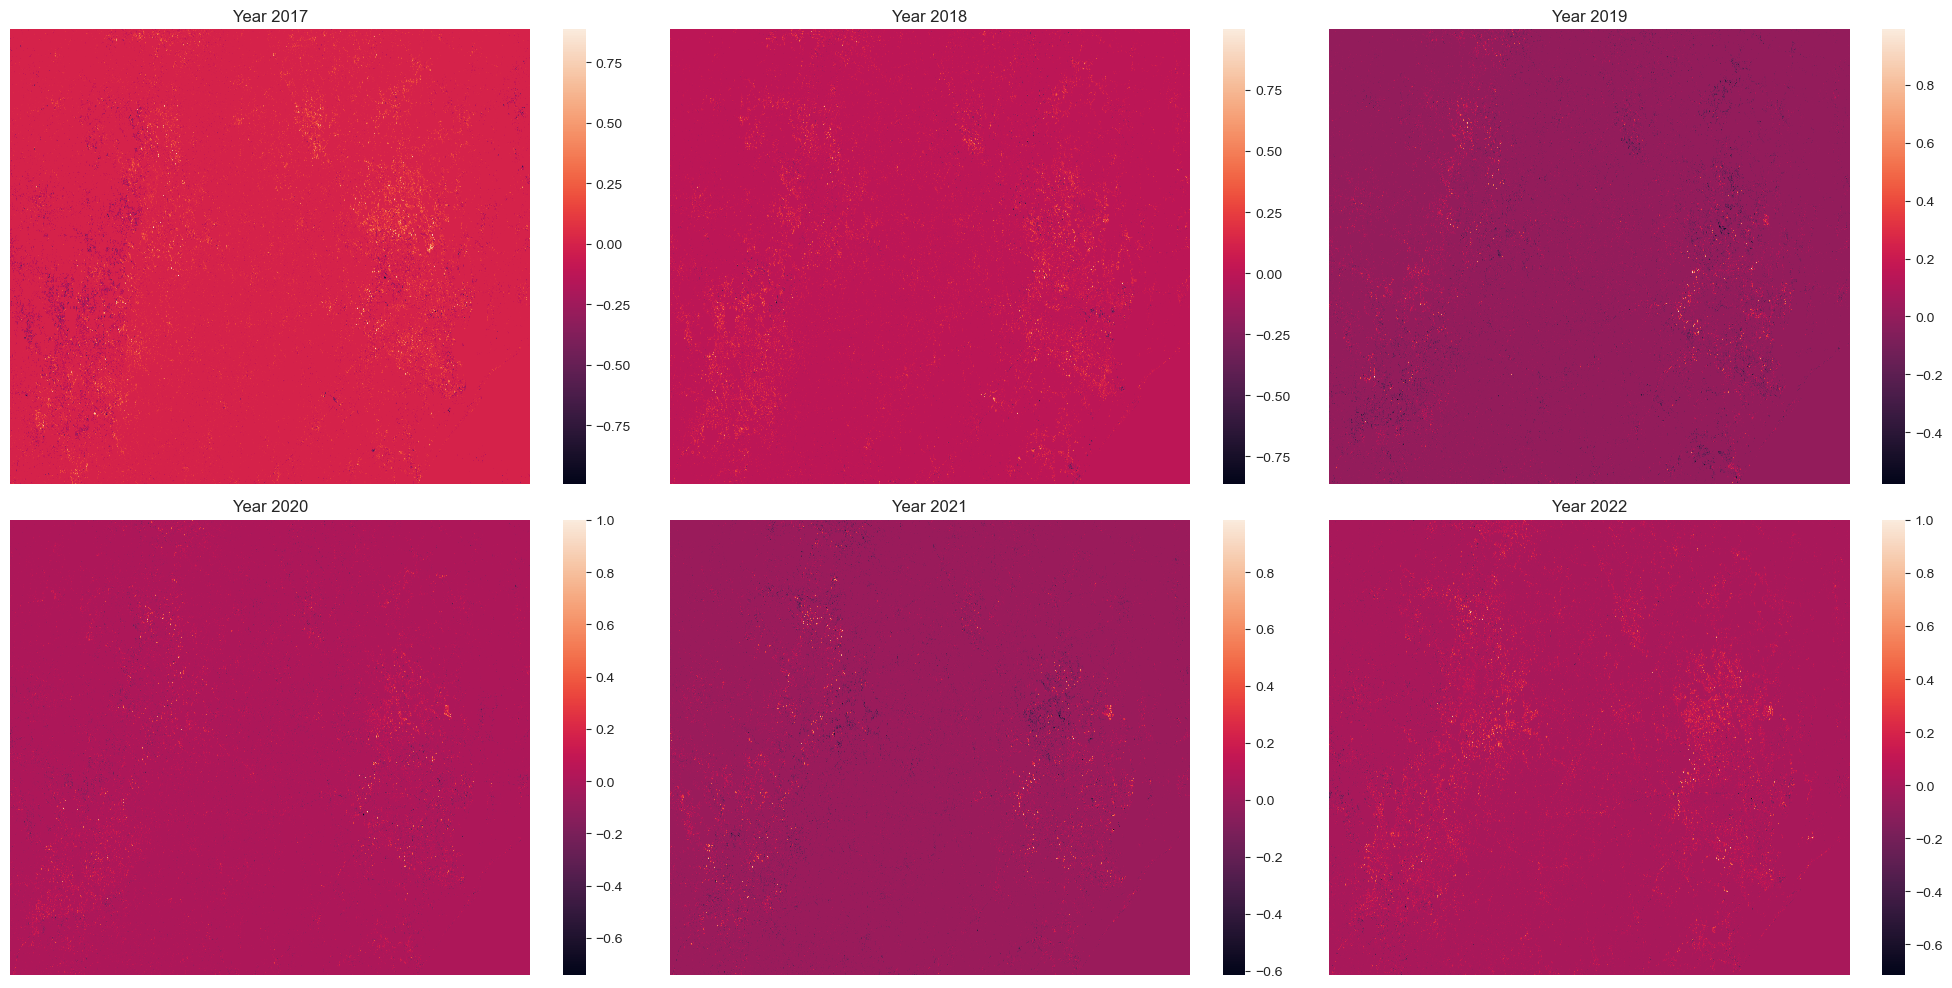

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):
    # Plot the heatmap
    sns.heatmap(tensor[i, :, :, 0], ax=ax[i//3, i%3], cmap='rocket')
    ax[i//3, i%3].set_title(f"Year {years[i]}")
    ax[i//3, i%3].set_xticks([])
    ax[i//3, i%3].set_yticks([])
plt.tight_layout()
plt.show()

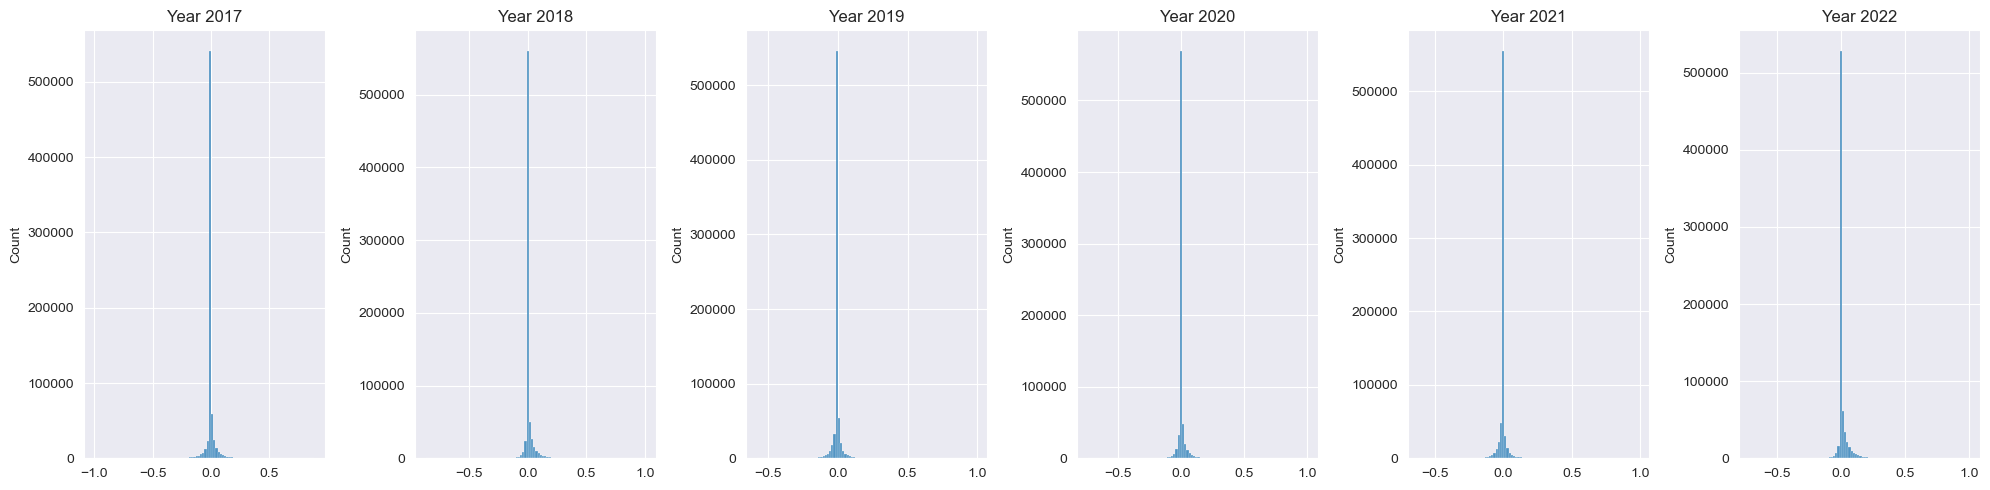

In [7]:
# plot the urbanization rate histogram seaborn

fig, ax = plt.subplots(1, 6, figsize=(20, 5))
for i in range(6):
    sns.histplot(tensor[i, :, :, 0].flatten(), ax=ax[i], bins=100)
    ax[i].set_title(f"Year {years[i]}")
    plt.tight_layout()

# Training Dataset Generation

Now, we need to generate the dataset. Therefore, we will define a data loader. We need to generate a dataset having the following dimensions:

`(NBR_SAMPLES, TIME_SEQ, IMG_WIDTH, IMG_HEIGHT, CHANNELS)`

In [8]:
def extract_submatrix(matrix, length, slide_size):
    """
    Extracts overlapping submatrices of a specified length from a given 2D matrix.

    Parameters:
        matrix (numpy.ndarray): The input 2D matrix from which submatrices will be extracted.
        length (int): The side length of the submatrices to be extracted.
        slide_size (int): The step size for sliding the extraction window.

    Returns:
        numpy.ndarray: An array containing the extracted submatrices as its elements.
    """
    submatrices = []
    rows, cols = matrix.shape
    for i in range(0, rows - (length - 1), slide_size):
        for j in range(0, cols - (length - 1), slide_size):
            submatrix = matrix[i:i+length, j:j+length]
            submatrices.append(submatrix)
    return np.array(submatrices)

def generate_submatrices(tensor, years, length, slide_size):
    """
    Generates overlapping submatrices from a 4D tensor, representing data for multiple years.

    Parameters:
        tensor (numpy.ndarray): The 4D tensor containing data for multiple years, where the first dimension
                                represents the year, and the other dimensions represent the spatial data.
        years (list): A list of year values corresponding to each data slice along the first dimension of tensor.
        length (int): The side length of the submatrices to be extracted.
        slide_size (int): The step size for sliding the extraction window.

    Returns:
        numpy.ndarray: An array containing the generated submatrices as its elements.
    """
    submatrices = []
    for i, yr in enumerate(years):
        mat = tensor[i, :, :, 0]
        submatrices.append(extract_submatrix(mat, length, slide_size))
    submatrices = np.array(submatrices)
    transposed_array = np.transpose(submatrices, (1, 0, 2, 3))
    reshaped_array = transposed_array.reshape((-1, len(years), length, length, 1))
    return reshaped_array

In [9]:
TIME_SEQ = 6  # frames
IMG_SIZE = 15  # tiles
SLIDE_WDW = 5 # tiles
years = ["2017", "2018", "2019", "2020", "2021", "2022"]

sub_matrices = generate_submatrices(tensor, years, IMG_SIZE, SLIDE_WDW)
sub_matrices.shape

(28441, 6, 15, 15, 1)

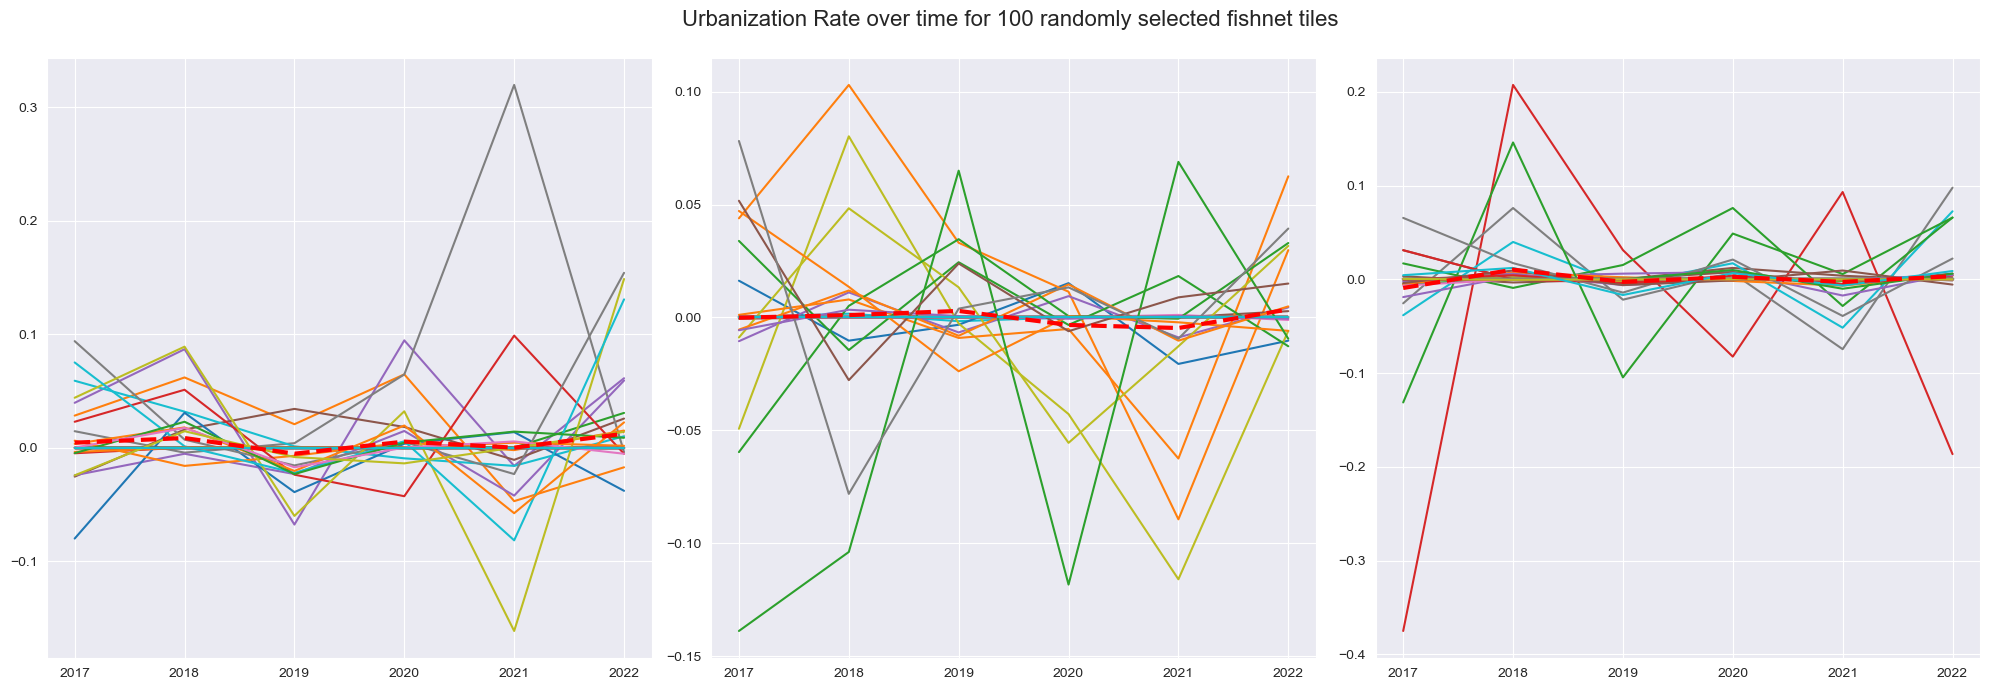

In [11]:
# Plot the yearly urbanization for 100 different tile_ids randomly selected
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
for subplot in ax:
    for _ in range(50):
        tile_id = np.random.choice(data["tile_id"].unique())
        subplot.plot(data[data["tile_id"]==tile_id]["year"], data[data["tile_id"]==tile_id]["urbanization_rate"])

    # title for the whole
    ax[1].set_title("Urbanization Rate over time for 100 randomly selected fishnet tiles \n", fontsize=16, loc="center")

    # Calculate and plot the average line
    avg_line = np.mean([line.get_ydata() for line in subplot.lines], axis=0)
    subplot.plot(data[data["tile_id"]==tile_id]["year"], avg_line, color="red", linestyle="--", label="Average", linewidth=3)

# plt.title("Urbanization over time for 100 randomly selected fishnet tiles", fontsize=16, loc="left")
plt.tight_layout()
plt.show()


Displaying frames for example 9282.


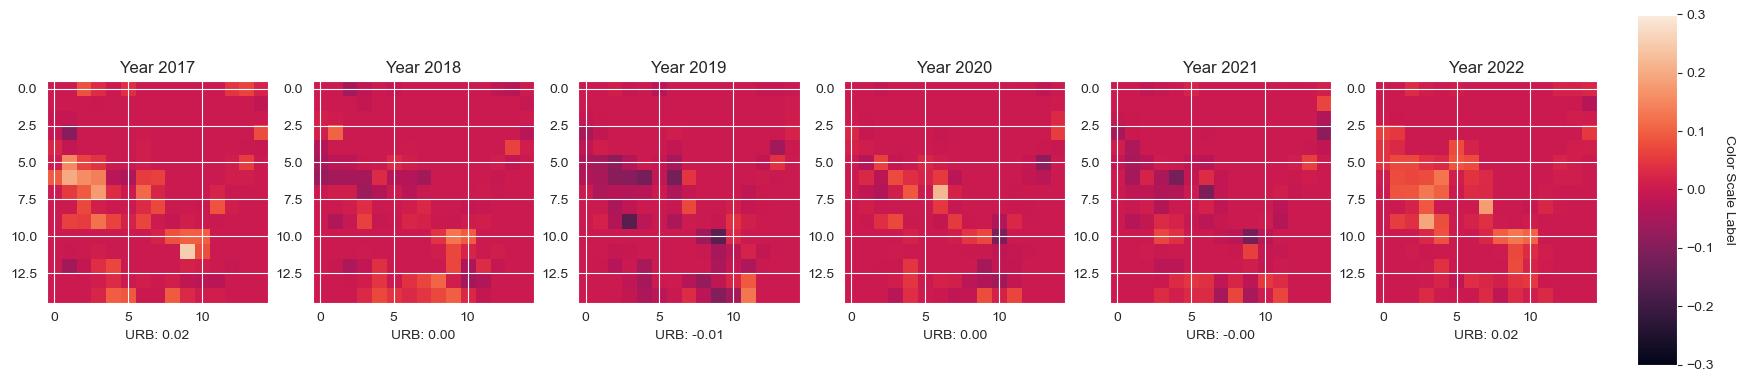

In [18]:
nbr_years = len(years)
min_val = -0.3
max_val = 0.3

fig, axes = plt.subplots(1, nbr_years, figsize=(20, 5))
data_choice = np.random.choice(range(len(sub_matrices)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    im = ax.imshow(np.squeeze(sub_matrices[data_choice][idx]), cmap="rocket", vmin=min_val, vmax=max_val)
    ax.set_title(f"Year {years[idx]}")
    ax.set_xlabel(f"URB: {np.mean(sub_matrices[data_choice][idx]):.2f}")
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size of the colorbar
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Color Scale Label', rotation=270, labelpad=15)

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()


# Generate the training dataset

In [15]:
def generate_shited_frames(data, type):
    shape = data.shape
    if type == "train":
        x_1 = data[:, 0 : 3, :, :]
        y_1 = data[:, 3, :, :]
        x_2 = data[:, 1 : 4, :, :]
        y_2 = data[:, 4, :, :]
        x = np.concatenate((x_1, x_2))
        y = np.concatenate((y_1, y_2)).reshape((data.shape[0]*2,1, data.shape[2], data.shape[3], data.shape[4]))
    elif type == "validation":
        x = data[:, 2 : 5, :, :]
        y = data[:, 5, :, :].reshape(data.shape[0],1, data.shape[2], data.shape[3], data.shape[4])
    else:
        raise ValueError("Type must be train or validation")
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = generate_shited_frames(sub_matrices, "train")
x_val, y_val = generate_shited_frames(sub_matrices, "validation")

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (56882, 3, 15, 15, 1), (56882, 1, 15, 15, 1)
Validation Dataset Shapes: (28441, 3, 15, 15, 1), (28441, 1, 15, 15, 1)


### Filter the training dataset 

As shown before, we have a massive amount of tiles with a *null* urbanization. We want to discard these inputs to void polluting the training with black/nearly black image sequesnces. In practice, as we will show this means that we are mostly training the CNN around urbanized areas (like cities). For the other areas, another model will have to be trained later.

Therefore, we want to keep only the sequences having an urbanization rate in year 3 outside [-X, X].

- `How do we define X?`
0.01 (1% urbanization variations)

In [39]:
def filter_data(X, threshold, years):
    if years == "last":
        mask = np.abs(X[:, -1, :, :, 0].mean(axis=(1, 2))) > threshold
    elif years == "avg":    
        mean_across_years = X.mean(axis=1)
        mask = np.abs(mean_across_years[:, :, :, 0]).mean(axis=(1, 2)) > threshold
    else: 
        raise ValueError("Years must be in last or avg")
    labels = np.where(mask, "train", "skip")
    return labels, mask

def merge_lists(train_skip_list, y_pred_f, y_pred_s):
    """
    Merge predictions from two lists based on a train_skip_list.

    This function takes three inputs: 'train_skip_list', 'y_pred_f', and 'y_pred_s'.
    
    Parameters:
    train_skip_list (list): A list of strings representing the actions for merging the predictions.
                            Each element of the list can be either 'train' or 'skip'.
                            'train' indicates taking the prediction from 'y_pred_f',
                            and 'skip' indicates taking the prediction from 'y_pred_s'.
                            
    y_pred_f (numpy.ndarray): A 3D numpy array containing predictions for 'train' samples.
                              The shape should be (num_train, height, width).
                              
    y_pred_s (numpy.ndarray): A 3D numpy array containing predictions for 'skip' samples.
                              The shape should be (num_skip, height, width).

    Returns:
    numpy.ndarray: A 3D numpy array containing the merged predictions based on 'train_skip_list'.
                   The shape will be (num_merged, height, width).
    """
    idx_f = 0
    idx_s = 0
    merged_list = []
    dim = y_pred_f.shape[1:]

    for item in train_skip_list:
        if item == 'train':
            merged_list.append(y_pred_f[idx_f].reshape(dim))
            idx_f += 1
        elif item == 'skip':
            merged_list.append(y_pred_s[idx_s].reshape(dim))
            idx_s += 1

    return np.array(merged_list)

We will be excluding all points that have an average urbanization rate lower than `THRESHOLD` using the `filter_data` function above. We will only train the Conv-LSTM on the training points. For the points outside urban areas, we will simply predict weros. Later, we will use the `merge_lists` function to merge the Conv-LSTM results (`y_pred_f`) with the zeros generate (`y_pred_s`).

In [40]:
THRESHOLD = 0.005
method = "last" #"avg"

train_idx, train_mask = filter_data(x_train, THRESHOLD, "last")
x_train_f, y_train_f = x_train[train_mask], y_train[train_mask]
x_train_s, y_train_s = x_train[~train_mask], y_train[~train_mask]

val_idx, val_mask = filter_data(x_val, THRESHOLD, "last")
x_val_f, y_val_f = x_val[val_mask], y_val[val_mask]
x_val_s, y_val_s = x_val[~val_mask], y_val[~val_mask]

In [41]:
train_idx

array(['skip', 'skip', 'skip', ..., 'skip', 'skip', 'skip'], dtype='<U5')

As a recall, the points used to train, will be:

- x_train_f
- y_train_f

And the validation dataset will be:
- x_val_f
- y_val_f

Find the dimensions below.

In [43]:
print(x_train_f.shape)
print(y_train_f.shape)

print(x_train_s.shape)
print(y_train_s.shape)

print(x_val_f.shape)
print(y_val_f.shape)

print(x_val_s.shape)
print(y_val_s.shape)

(16220, 3, 15, 15, 1)
(16220, 1, 15, 15, 1)
(40662, 3, 15, 15, 1)
(40662, 1, 15, 15, 1)
(8510, 3, 15, 15, 1)
(8510, 1, 15, 15, 1)
(19931, 3, 15, 15, 1)
(19931, 1, 15, 15, 1)


In [44]:
# Create a Keras input dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_f, y_train_f))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_f, y_val_f))

In [45]:
# How to get one pair (X,y) ? 
train_iter = iter(train_dataset)
x, y = next(train_iter)
print(x.shape)
print(y.shape)

(3, 15, 15, 1)
(1, 15, 15, 1)


# Data Augmentation

We will apply the following data augmentation to increase the size of our dataset.

1. Rotation (90, 180 and 270 degrees)

2. Vertical and Horizontal Symmetries

In [46]:
def rotate_image(image, k):
    return tf.image.rot90(image, k)

def augment(x, y):
    # Random rotation between -90 and 180 degrees
    k = np.random.choice([-1, 0, 1, 2])
    x_aug = tf.map_fn(lambda image: rotate_image(image, k), x)
    y_aug = tf.map_fn(lambda image: rotate_image(image, k), y)

    # Horizontal flip
    l = np.random.choice([0, 1])
    if l == 0:
        x_aug = tf.image.flip_left_right(x_aug)
        y_aug = tf.image.flip_left_right(y_aug)

    # Vertical flip
    m = np.random.choice([0, 1])
    if m == 0:
        x_aug = tf.image.flip_up_down(x_aug)
        y_aug = tf.image.flip_up_down(y_aug)

    return x_aug, y_aug

In [47]:
train_iter = iter(train_dataset)
X, y = next(train_iter)
X_aug, y_aug = augment(X, y) 

In [48]:
AUTOTUNE = tf.data.AUTOTUNE
aug_train_dataset = train_dataset.map(lambda x, y: (augment(x, y)), 
                num_parallel_calls=AUTOTUNE)

# Visualize the data augmentation

In [49]:
def plot_seq(x,y):
    TIME_SEQ = x.shape[0]
    fig, axes = plt.subplots(1, TIME_SEQ+1, figsize=(10, 4))
    for i in range(TIME_SEQ):
        axes[i].imshow(x[i, :, :, 0], cmap='gray')
    axes[TIME_SEQ].imshow(y[0, :, :, 0], cmap='gray')
    plt.tight_layout()

def plot_seq_aug(x, y, x_aug, y_aug):
    TIME_SEQ = x.shape[0]
    fig, axes = plt.subplots(2, TIME_SEQ+1, figsize=(10, 4))
    for i in range(TIME_SEQ):
        axes[0, i].imshow(x[i, :, :, 0], cmap='gray')
        axes[1, i].imshow(x_aug[i, :, :, 0], cmap='gray')

    axes[0, TIME_SEQ].imshow(y[0, :, :, 0], cmap='gray')
    axes[1, TIME_SEQ].imshow(y_aug[0, :, :, 0], cmap='gray')
    
    # add titles to each subrow
    axes[0, 2].set_title('Original')
    axes[1, 2].set_title('Augmented')
    plt.tight_layout()


In [50]:
train_iter = iter(train_dataset)
aug_train_iter = iter(aug_train_dataset)

2023-07-18 13:47:10.649393: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


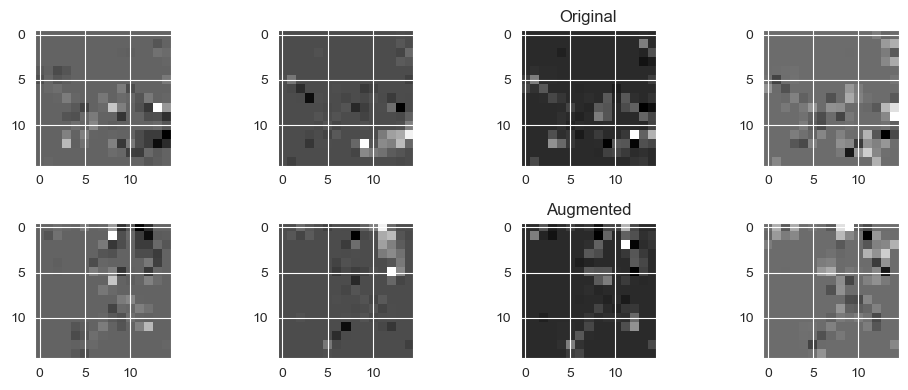

In [51]:
# get a random element from train_dataset
x, y = next(train_iter)
x_aug, y_aug = next(aug_train_iter)

plot_seq_aug(x, y, x_aug, y_aug)

# Training the model

## Prepare the data

In [52]:
def prepare(ds, batch_size, shuffle=False, augment=None):

    # Augment data
    if shuffle:
        ds = ds.shuffle(1000)

    # Apply mapping function
    if augment is not None:
        # ds_aug = ds.map(lambda x, y: augment(x, y), 
        #         num_parallel_calls=AUTOTUNE)
        ds_aug = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.concatenate(ds_aug)

    # Batch all datasets.
    ds = ds.batch(batch_size)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [53]:
batch_size = 64

train_ds = prepare(train_dataset, batch_size, shuffle=True, augment=augment)
val_ds = prepare(val_dataset, batch_size)

In [54]:
def create_model():
    # Construct the input layer with 4 time frames in input
    inp = layers.Input(shape=(3, *x_train.shape[2:]))

    # We will construct 3 `ConvLSTM2D` layers with batch normalization,
    # followed by a `Conv3D` layer for the spatiotemporal outputs.
    x = layers.ConvLSTM2D(
        filters=64,                # transform each image into a 64 channel image 
        kernel_size=(3, 3),        # each image [7,7] --> [5,5] (with 64 channels, see above, filters)
        padding="same",           # valid: no padding (so image stays [5,5], same: padding so image stays [6x6])
        return_sequences=True,
        activation="relu",
    )(inp)
    x = layers.BatchNormalization()(x)   # improve the training speed, stability, and generalization of the network
    x = layers.ConvLSTM2D(
        filters=64,                      # 
        kernel_size=(3, 3),              # each previous [5,5] image --> [3,3] image
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(1, 1),
        padding="same",
        return_sequences=False,
        activation="relu",
    )(x)
    x = layers.Conv2D(
        filters=1,               # 1 filter leads to one chanel in the output
        kernel_size=(3, 3),   # 
        activation="sigmoid", 
        padding="same"
    )(x)

    # Next, we will build the complete model and compile it.
    model = keras.models.Model(inp, x)
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())
    return model

# Train the model from scratch
model = create_model()

# Use a pretrained model from HuggingFace (https://huggingface.co/keras-io/conv-lstm)
# model_path = "./pretrained-models/"
# model = tf.keras.models.load_model(model_path)

In [55]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Training the model

In [569]:
# Set tensorboard Callback
log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 200

# Fit the model to the training data.
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[tensorboard_callback],#early_stopping, reduce_lr],
)

Epoch 1/200
26/26 [==============================] - 14s 436ms/step - loss: 0.0709 - val_loss: 0.1600
Epoch 2/200
26/26 [==============================] - 12s 472ms/step - loss: 0.0035 - val_loss: 0.0494
Epoch 3/200
26/26 [==============================] - 12s 450ms/step - loss: 0.0035 - val_loss: 0.0192
Epoch 4/200
26/26 [==============================] - 11s 423ms/step - loss: 0.0035 - val_loss: 0.0102
Epoch 5/200
26/26 [==============================] - 11s 421ms/step - loss: 0.0035 - val_loss: 0.0070
Epoch 6/200
26/26 [==============================] - 11s 424ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 7/200
26/26 [==============================] - 12s 452ms/step - loss: 0.0035 - val_loss: 0.0051
Epoch 8/200
26/26 [==============================] - 13s 492ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 9/200
26/26 [==============================] - 11s 429ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 10/200
26/26 [==============================] - 11s 435ms/step - loss: 0.003

KeyboardInterrupt: 

# Tensorboard

In [ ]:
# Clear any logs from previous runs
%rm -rf ./logs/

In [ ]:
# command to kill tensorboard process on port 6006: kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
# Run TensorBoard
%reload_ext tensorboard
%tensorboard --logdir=logs

Reusing TensorBoard on port 6006 (pid 30937), started 0:00:17 ago. (Use '!kill 30937' to kill it.)

# Train the XGBoost the perform the final prediction

In [57]:
y_pred_f = model.predict(x_val_f)

266/266 [==============================] - 18s 67ms/step


In [58]:
# Reminder: y_val_s are the data points that we skipped earlier, to which we basically assign the same urbanization as the year before.
y_pred = merge_lists(val_idx, y_pred_f, y_val_s)

In [59]:
y_pred.shape

(28441, 15, 15, 1)

# XGBoost

Now that we have the predictions for each element of the validation set. As we are currently using an input of dimensions [15,15] and a sliding window of size 5, we get 9 predictions for each fishnet tile in total. Therefore, we will extract these 9 predictions for each fishnet tile and train an XGBoost model to predict the final urbanization rate.

In [90]:
# create list to save result for each tile
tile_predictions = [[] for i in range(len(data.tile_id.unique()))]

In [91]:
# return upper left coordinates of each submatrix
def submatrix_coordinates(length, slide_size, rows, cols):
    coordinates = []
    for i in range(0, rows - (length - 1), slide_size):
        for j in range(0, cols - (length - 1), slide_size):
            coordinates.append((i,j))
    return np.array(coordinates)

coordinates = submatrix_coordinates(IMG_SIZE, SLIDE_WDW, rows, cols)

y_pred is y_pred_f when make a prediction, x_val_s[:,-1,:,:,0] othewise




In [92]:
for coords, submatrix in zip(coordinates, y_pred):

  # index of pred_index corresponding to upper left coordinate
  ul_idx = coords[1] + coords[0] * cols

  # from (IMG_SIZE, IMG_SIZE, 1) to (IMG_SIZE, IMG_SIZE)
  submatrix = submatrix.reshape(IMG_SIZE, IMG_SIZE)

  for i in range(IMG_SIZE):

    # take row, first element is mapped to ul_idx, second element is mapped to ul_idx + 1, ... , last element to ul_idx + IMG_SIZE - 1
    row = submatrix[i, :]

    for j in range(IMG_SIZE): # for each column

      tile_predictions[ul_idx + i * cols + j].append(row[j])

Check distribution, how many

Counter({9: 693225, 3: 17700, 6: 17700, 0: 1205, 2: 200, 1: 100, 4: 100})


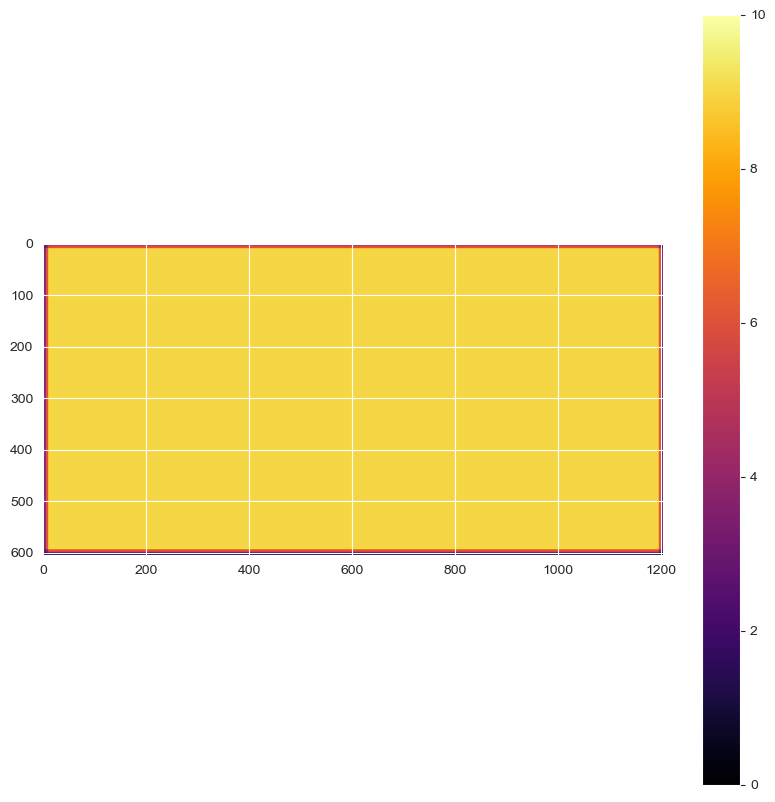

In [104]:
n_elements = [len(i) for i in tile_predictions]

from collections import Counter
print(Counter(n_elements))

# set vmin vmax
min_val = 0
max_val = 10

# plot heatmap
plt.figure(figsize=(10, 10))
plt.imshow(np.array(n_elements).reshape(rows, cols), cmap="inferno", vmin=min_val, vmax=max_val)
plt.colorbar()
plt.show()

#### Interpretation:

As you can see on this plot, we have *9 tiles* for most of the fishnet. Therefore, we will only consider the yellow tiles on the graph above only, and we discard the others. This is not limiting us as we could always extract a slightly bigger region from Dynamic World. The outer areas would mostly be areas outside the US / in the ocean, thus, not limiting the analysis.

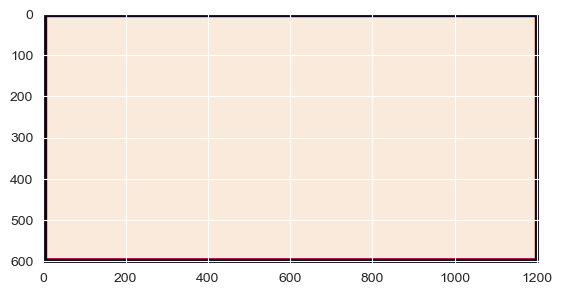

In [112]:
idx = [i for i, x in enumerate(tile_predictions) if len(x) == 9]
mask = np.where(np.array(n_elements) == 9, True, False)
plt.imshow(mask.reshape(rows, cols))

In [113]:
pred_value = []
for i in range(len(tile_predictions)):
  # np.append(pred_value, np.mean(tile_predictions[i]))
  pred_value.append(np.mean(tile_predictions[i]))

# apply the mask
pred_value = np.array(pred_value)[mask]

# Baseline
We take the average of all 9 predictions as the final urbanization rate.

In [122]:
from sklearn.metrics import mean_squared_error as mse

In [123]:
data_value = data[data.year == 2022].urbanization_rate.reset_index(drop=True)[mask]

In [124]:
mse(data_value, pred_value)

0.05146518060311387

In [125]:
from sklearn.metrics import r2_score
r2_score(data_value, pred_value) # (test, pred)

-29.16766325971846

# XGBoost Model

In [134]:
data.head()

,tile_id,batch_id,year,urbanization_rate,urbanization,Lat,Lon
0,4879217,1225,2017,0.0,0.0,31.100095,-99.130546
1,4879217,1225,2018,0.0,0.0,31.100095,-99.130546
2,4879217,1225,2019,0.0,0.0,31.100095,-99.130546
3,4879217,1225,2020,0.0,0.0,31.100095,-99.130546
4,4879217,1225,2021,0.0,0.0,31.100095,-99.130546


In [135]:
# return id of tiles for which make prediction
tile_id_predicted = np.array(data[data.year == 2022].tile_id.reset_index(drop=True)[idx])

In [136]:
tile_pred_values = np.array([x for x in tile_predictions if len(x) == 9])

In [140]:
# create dataframe
df = pd.DataFrame(data = tile_pred_values, index = tile_id_predicted, columns = [f"tile_{i+1}" for i in range(9)])

# Add absolute value urbanization value to the dataset
for year in range(2017, 2021+1):
  df[f"{year}"] = data[data.year == year].urbanization.reset_index(drop = True)[idx].values

# add Lat, Long
df['Lat'] = data[data.year == 2022].Lat.reset_index(drop = True)[idx].values
df['Lon'] = data[data.year == 2022].Lon.reset_index(drop = True)[idx].values

df.head()

,tile_1,tile_2,tile_3,tile_4,tile_5,tile_6,tile_7,tile_8,tile_9,2017,2018,2019,2020,2021,Lat,Lon
4911917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.063912,-99.090344
4911918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.063912,-99.086324
4911919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.063912,-99.082304
4911920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.063912,-99.078284
4911921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.063912,-99.074263


In [745]:
X = df.values
y = data_value.values
# y = data[data.year == '2022'].urbanization.values[mask]

In [746]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [747]:
# define XGboost model and fit
from xgboost import XGBRegressor
model = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [757]:
# evaluate performance on test
np.sqrt(mse(y_test, y_pred))

0.0364454752856787

In [761]:
np.sqrt(mse(y_test, y_pred)) / data.urbanization.mean()

0.07532466433018527

In [762]:
data.urbanization.mean()

0.4838451735532488

Text(0.5, 1.0, 'XGBoost Model')

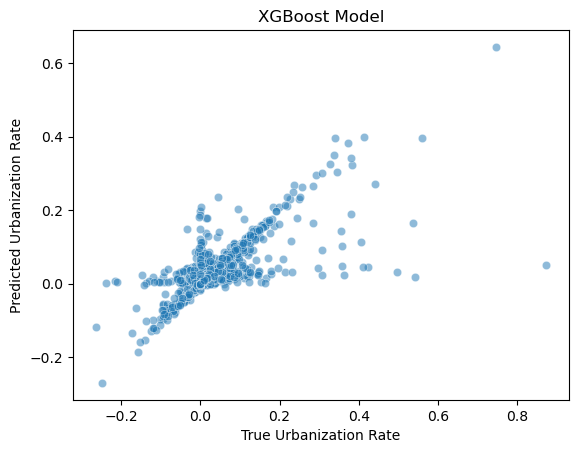

In [749]:
# plot the results with seaborn beautiful
import seaborn as sns

# scatterplot with alpha
sns.scatterplot(x = y_test, y = y_pred, alpha = 0.5)
plt.xlabel('True Urbanization Rate')
plt.ylabel('Predicted Urbanization Rate')
plt.title('XGBoost Model')

# Be a little more conservation - exclude less data points to avoid the horrizontal line where we predict 0 whereas it is in fact not the case.

In [743]:
# compute r-squared
r2_score(y_test, y_pred)

0.9823226938557996

In [698]:
# fc.filtered_fishnet['centroid'] = fc.filtered_fishnet['geometry'].centroid

# using lambda


In [701]:
data.head()

,tile_id,batch_id,year,urbanization_rate,urbanization
0,6060154,23743,2017,0.063333,0.710556
1,6060155,23743,2017,0.033523,0.802841
2,6060156,23743,2017,-0.028333,0.550000
3,6060157,23743,2017,-0.052778,0.447222
4,6060158,23743,2017,0.006667,0.773333


Text(0.5, 1.0, 'Feature Importance')

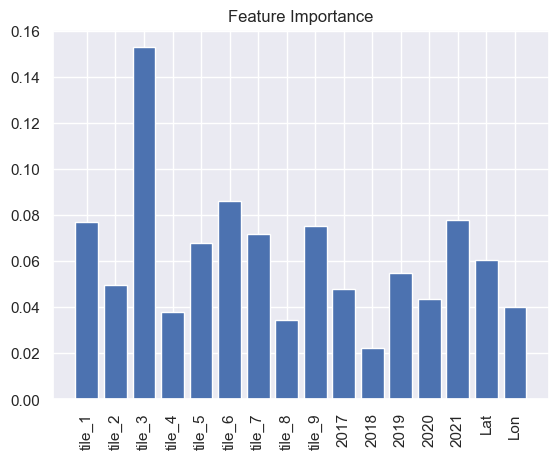

In [756]:
# print feature importance
model.feature_importances_

# plot it
import matplotlib.pyplot as plt
# use seaborn
import seaborn as sns
sns.set()

# plot this with seaborn plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)

# rename x-ticks with x_axis_names = df.columns
plt.xticks(range(len(model.feature_importances_)), df.columns, rotation = 90)

# title
plt.title('Feature Importance')


In [751]:
df.columns


Index(['tile_1', 'tile_2', 'tile_3', 'tile_4', 'tile_5', 'tile_6', 'tile_7',
       'tile_8', 'tile_9', '2017', '2018', '2019', '2020', '2021', 'Lat',
       'Lon'],
      dtype='object')

# Analyze the results

Let's work on one tile. Let's assume that we predict the next urbanization rate of that specific tile.

1. Compute total R2 for that prediction ?

In [ ]:
# predict the values of the test set using keras
y_pred_f = model.predict(x_val_f)

12/12 [==============================] - 7s 547ms/step


In [ ]:
# flatten the y tensors
y_pred_flat = y_pred.flatten()
y_val_flat = y_val_f.flatten()

# compute the MSE and RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y_val_flat, y_pred_flat)
rmse = sqrt(mse)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MSE: 0.00457463486892215
RMSE: 0.06763604711189256


# Baseline Model

Let's define two baseline models here: 

1. Taking the average of urbanization over the last 4 years to predict the fifth one.
2. Using an XGBoost to predict the 5th one based on the 4 previous years. 


### `Baseline 1`


#### URBANIZATION

In [ ]:
# Test set
x_test = tensor[2:6, :, :, 0]
y_test = tensor[6, :, :, 0]

# mean of the last 4 years
y_pred_baseline = np.mean(x_test, axis=0)

# %%
# compute mse and r2 with scikitlearn
from sklearn.metrics import mean_squared_error, r2_score

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Baseline MSE: {mse_baseline}")
print(f"Baseline R2: {r2_baseline}")

Baseline MSE: 0.005912100328010498
Baseline R2: 0.96028700772427


#### URBANIZATION RATE

In [ ]:
# Test set
x_test = tensor[2:6, :, :, 0] - tensor[1:5, :, :, 0]
y_test = tensor[6, :, :, 0] - tensor[5, :, :, 0]

# mean of the last 4 years
y_pred_baseline = np.mean(x_test, axis=0)

# set negative values to 0
y_pred_baseline[y_pred_baseline < 0] = 0
y_test[y_test < 0] = 0

# %%
# compute mse and r2 with scikitlearn
from sklearn.metrics import mean_squared_error, r2_score

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"Baseline MSE: {mse_baseline}")
print(f"Baseline R2: {r2_baseline}")

Baseline MSE: 0.002855942525584417
Baseline R2: -0.2421209937368897


### `Baseline 2`

Let's train an XGBoost Model using the same data and analyze the results that we obtain.

#### URBANIZATION

In [ ]:
x_train_1 = tensor[0:4, :, :, 0].reshape(4,-1)
y_train_1 = tensor[4, :, :, 0].reshape(-1)
x_train_2 = tensor[1:5, :, :, 0].reshape(4,-1)
y_train_2 = tensor[5, :, :, 0].reshape(-1)
x_train = np.concatenate((x_train_1, x_train_2), axis=1).transpose()
y_train = np.concatenate((y_train_1, y_train_2), axis=0)

x_test = tensor[2:6, :, :, 0].reshape(4,-1).transpose()
y_test = tensor[6, :, :, 0].reshape(-1)

In [ ]:
# Train an XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=42)

# Fit the regressor to the training set
xg_reg.fit(x_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(x_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))

# Print rmse
print("RMSE: %f" % (rmse))

# MSE
mse_baseline = mean_squared_error(y_test, preds)
print(f"Baseline MSE: {mse_baseline}")

# compute the R^2
from sklearn.metrics import r2_score

r2_score(y_test, preds)
print(f"Baseline R2: {r2_score(y_test, preds)}")

# compute TSS and RSS
TSS = np.sum((y_test - np.mean(y_test))**2)
RSS = np.sum((y_test - preds)**2)
print(f"TSS: {TSS}")
print(f"RSS: {RSS}")
print(f"R2: {1 - RSS/TSS}")

RMSE: 0.055752
Baseline MSE: 0.003108281234879888
Baseline R2: 0.9810506807933904
TSS: 3703.9905127747807
RSS: 70.18809856482275
R2: 0.9810506807933904


### URBANIZATION RATE

In [ ]:
x_train_1 = tensor[0:4, :, :, 0].reshape(4,-1)
y_train_1 = tensor[4, :, :, 0].reshape(-1) - tensor[3, :, :, 0].reshape(-1)
x_train_2 = tensor[1:5, :, :, 0].reshape(4,-1)
y_train_2 = tensor[5, :, :, 0].reshape(-1) - tensor[4, :, :, 0].reshape(-1)
x_train = np.concatenate((x_train_1, x_train_2), axis=1).transpose()
y_train = np.concatenate((y_train_1, y_train_2), axis=0)

x_test = tensor[2:6, :, :, 0].reshape(4,-1).transpose()
y_test = tensor[6, :, :, 0].reshape(-1) - tensor[5, :, :, 0].reshape(-1)

# set negative values to 0
y_train[y_train < 0] = 0
y_test[y_test < 0] = 0

In [ ]:
# Train an XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=42)

# Fit the regressor to the training set
xg_reg.fit(x_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(x_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))

# Print rmse
print("RMSE: %f" % (rmse))

# MSE
mse_baseline = mean_squared_error(y_test, preds)
print(f"Baseline MSE: {mse_baseline}")

# compute the R^2
from sklearn.metrics import r2_score

r2_score(y_test, preds)
print(f"Baseline R2: {r2_score(y_test, preds)}")

# compute TSS and RSS
TSS = np.sum((y_test - np.mean(y_test))**2)
RSS = np.sum((y_test - preds)**2)
print(f"\n TSS: {TSS}")
print(f"RSS: {RSS}")
print(f"R2: {1 - RSS/TSS}")

RMSE: 0.045984
Baseline MSE: 0.00211449796088774
Baseline R2: 0.1588245384963184

 TSS: 56.76280471787999
RSS: 47.74747845480606
R2: 0.1588245384963184


In [ ]:
data.head()

,tile_id,batch_id,year,urbanization
0,6060154,23743,2016,0.710556
1,6060155,23743,2016,0.802841
2,6060156,23743,2016,0.550000
3,6060157,23743,2016,0.447222
4,6060158,23743,2016,0.773333


(array([44951.,  5266.,  4379.,  3834.,  3576.,  3484.,  3291.,  3235.,
         3334.,  3452.,  3474.,  3638.,  3815.,  4071.,  4462.,  5018.,
         5649.,  6269.,  7788., 35081.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

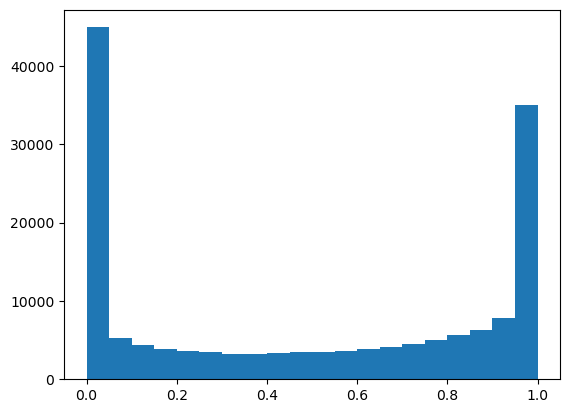

In [ ]:
# histogram of urbanization
plt.hist(data["urbanization"], bins=20)

In [ ]:
dcc.head()

year,2016,2017,2018,2019,2020,2021,2022,urbanization_rate_2017,urbanization_rate_2018,urbanization_rate_2019,urbanization_rate_2020,urbanization_rate_2021,urbanization_rate_2022
tile_id,,,,,,,,,,,,,
6060154,0.710556,0.773889,0.871667,0.861111,0.886111,0.913889,0.929444,0.063333,0.097778,-0.010556,0.025000,0.027778,0.015556
6060155,0.802841,0.836364,0.899432,0.896023,0.905682,0.931818,0.948295,0.033523,0.063068,-0.003409,0.009659,0.026136,0.016477
6060156,0.550000,0.521667,0.536111,0.577778,0.583333,0.661111,0.661111,-0.028333,0.014444,0.041667,0.005556,0.077778,0.000000
6060157,0.447222,0.394444,0.448889,0.806667,0.877778,0.840000,0.852778,-0.052778,0.054444,0.357778,0.071111,-0.037778,0.012778
6060158,0.773333,0.780000,0.766111,0.827222,0.831667,0.768889,0.810000,0.006667,-0.013889,0.061111,0.004444,-0.062778,0.041111


<Axes: xlabel='year', ylabel='year'>

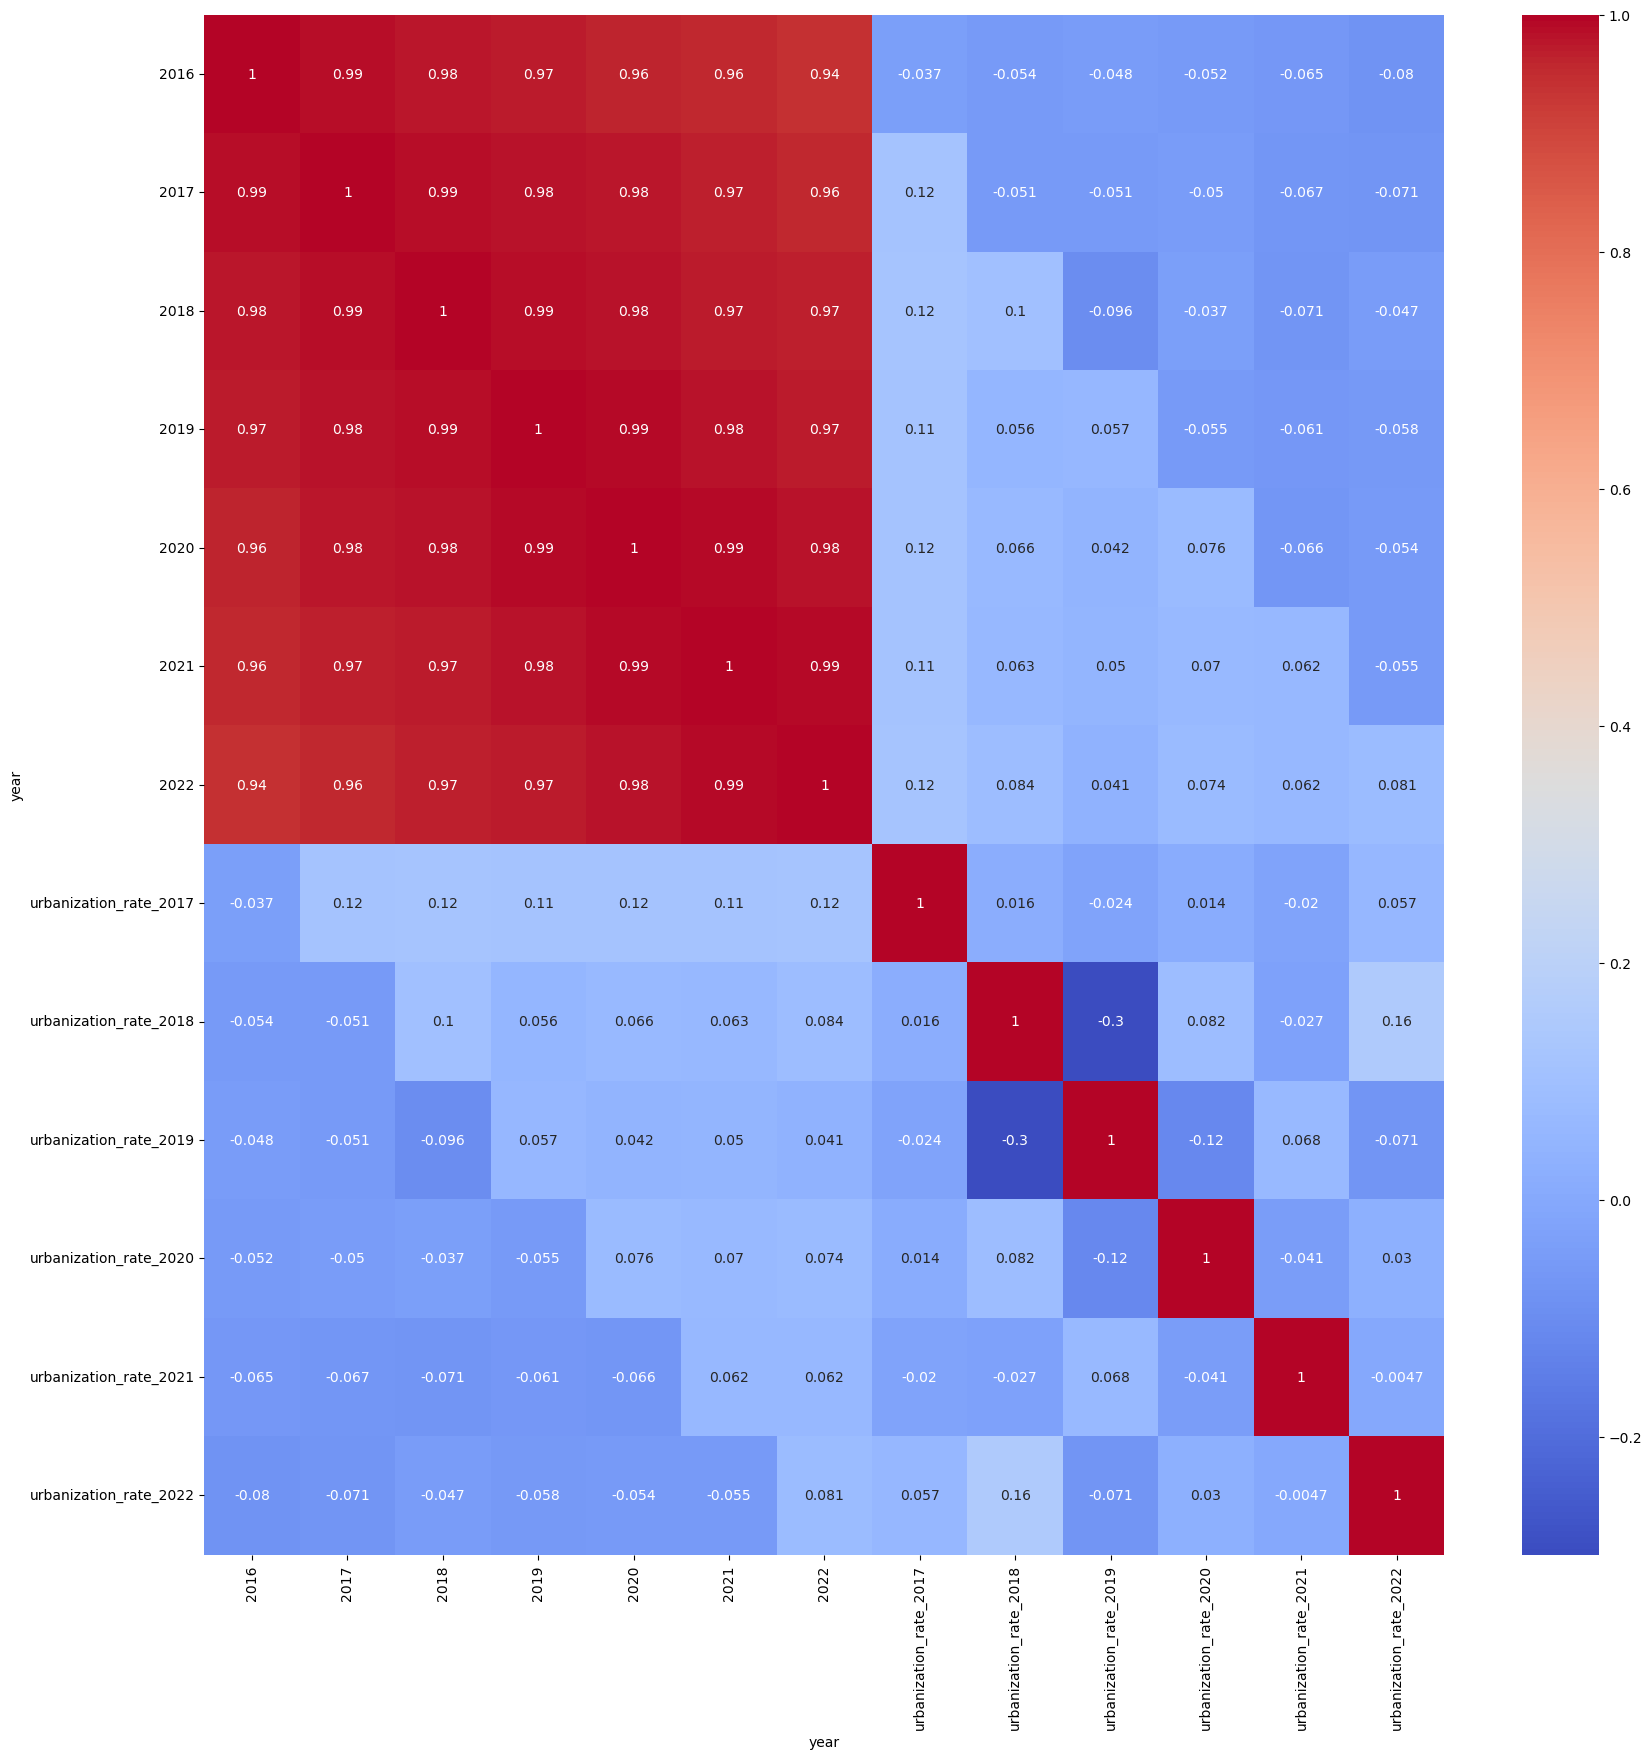

In [ ]:
# pivot wide to long on year
dcc = data.pivot(index="tile_id", columns="year", values="urbanization")

# compute urbanization rate
for year in [2017, 2018, 2019, 2020, 2021, 2022]:
    dcc[f"urbanization_rate_{year}"] = dcc[f"{year}"] - dcc[f"{year-1}"]

# set negative values to 0
# dcc[dcc < 0] = 0


import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(dcc.corr(), annot=True, cmap="coolwarm")

In [ ]:
dcc.head()

year,2016,2017,2018,2019,2020,2021,2022,urbanization_rate_2017,urbanization_rate_2018,urbanization_rate_2019,urbanization_rate_2020,urbanization_rate_2021,urbanization_rate_2022
tile_id,,,,,,,,,,,,,
6060154,0.710556,0.773889,0.871667,0.861111,0.886111,0.913889,0.929444,0.063333,0.097778,-0.010556,0.025000,0.027778,0.015556
6060155,0.802841,0.836364,0.899432,0.896023,0.905682,0.931818,0.948295,0.033523,0.063068,-0.003409,0.009659,0.026136,0.016477
6060156,0.550000,0.521667,0.536111,0.577778,0.583333,0.661111,0.661111,-0.028333,0.014444,0.041667,0.005556,0.077778,0.000000
6060157,0.447222,0.394444,0.448889,0.806667,0.877778,0.840000,0.852778,-0.052778,0.054444,0.357778,0.071111,-0.037778,0.012778
6060158,0.773333,0.780000,0.766111,0.827222,0.831667,0.768889,0.810000,0.006667,-0.013889,0.061111,0.004444,-0.062778,0.041111


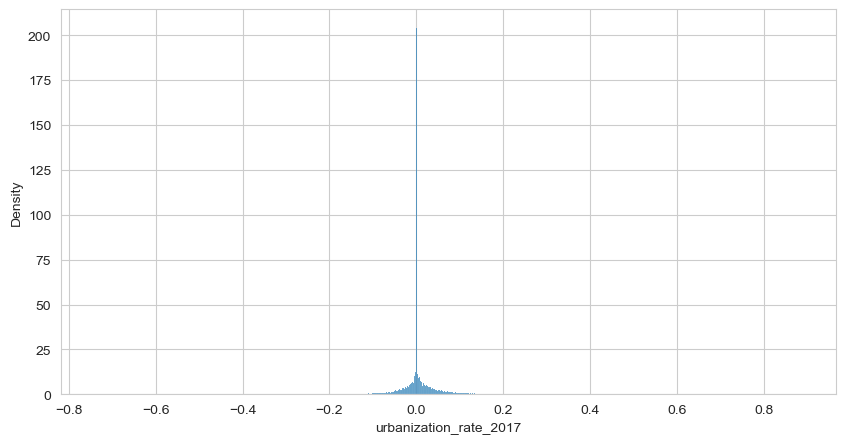

In [ ]:
# plot histogram for 2017 urbanization_rate_2017 with seaborn beautiful
# plt.figure(figsize=(10, 5))
# sns.histplot(dcc["urbanization_rate_2017"], bins=100)

# frequency?
plt.figure(figsize=(10, 5))
sns.histplot(dcc["urbanization_rate_2017"], bins=1000, stat="density")

# set style
sns.set_style("whitegrid")
# x axis -0.4 to 0.4
# plt.xlim(-0.4, 0.4)

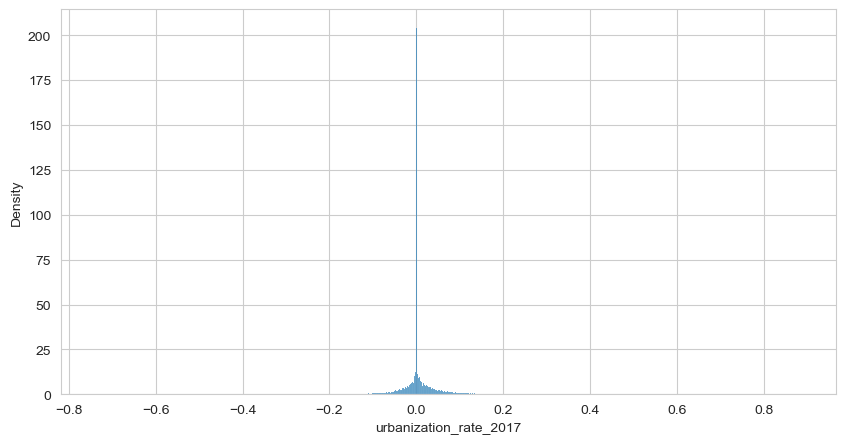

In [ ]:
# plot histogram for 2017 urbanization_rate_2017 with seaborn beautiful
# plt.figure(figsize=(10, 5))
# sns.histplot(dcc["urbanization_rate_2017"], bins=100)

# frequency?
plt.figure(figsize=(10, 5))
sns.histplot(dcc["urbanization_rate_2017"], bins=1000, stat="density")

# set style
sns.set_style("whitegrid")
# x axis -0.4 to 0.4
# plt.xlim(-0.4, 0.4)

### `Baseline 3`

Let's train an LSTM model taking 4 points as input and predicting the 5th.

In [ ]:
x_train_1 = tensor[0:4, :, :, 0].reshape(-1, 4)
y_train_1 = tensor[4, :, :, 0].reshape(-1)
x_train_2 = tensor[1:5, :, :, 0].reshape(-1,4)
y_train_2 = tensor[5, :, :, 0].reshape(-1)
x_train = np.concatenate((x_train_1, x_train_2), axis=0)
y_train = np.concatenate((y_train_1, y_train_2), axis=0)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Assuming you have your dataset ready, where each data point contains 4 input points and 1 output point
# X_train.shape should be (num_samples, 4, num_features) and y_train.shape should be (num_samples, 1, num_features)

# Define the number of LSTM units in the hidden layer
num_units = 512

# Define the input shape
input_shape = (4, 1)

# Create the LSTM model
model = Sequential()
model.add(LSTM(num_units, input_shape=input_shape))
model.add(Dense(1))  # Output layer with the same number of features as the input

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=512)

Epoch 1/50
89/89 [==============================] - 6s 60ms/step - loss: 0.1795 - val_loss: 0.1408
Epoch 2/50
89/89 [==============================] - 5s 58ms/step - loss: 0.1629 - val_loss: 0.1430
Epoch 3/50
16/89 [====>.........................] - ETA: 3s - loss: 0.1623

KeyboardInterrupt: 

In [ ]:
x_train.shape

(45162, 4)

In [ ]:
sample = pd.DataFrame(x_train).sample(100)

fig, ax  = plt.subplots(1, 4, figsize=(20, 5)) # 25 plots on each plot

,0,1,2,3
7242,0.728889,0.463333,0.012222,0.052222
29003,0.136043,0.230352,0.000000,0.000000
28783,1.000000,1.000000,1.000000,0.991111
15778,0.000000,0.353930,0.300813,0.272087
30932,0.054743,0.000000,0.000000,0.003794
...,...,...,...,...
4392,0.000000,0.000000,0.000000,0.000000
39779,0.695393,1.000000,0.501897,0.060976
44205,0.010556,0.000000,0.000000,0.000000
25605,1.000000,0.996667,1.000000,0.838333
